Here we show some plots to show the presence of mesoscale eddies in the different simulations. 

In [1]:
import numpy as np
import xarray as xr 
import matplotlib.pyplot as plt

In [2]:
import xgcm

In [3]:
## MITgcm sim 

from intake import open_catalog
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/channel.yaml")
ds_MITgcm = cat['run_tracers_restored_zarr'].to_dask()

/srv/conda/envs/notebook/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


In [4]:
## MOM6 
import gcsfs
import os
PERSISTENT_BUCKET = os.environ['PERSISTENT_BUCKET']
fs = gcsfs.GCSFileSystem()
fs.ls(f'{PERSISTENT_BUCKET}/MOM6/Phillips2Layer/')

ds_P2L = xr.open_zarr(f'{PERSISTENT_BUCKET}/MOM6/Phillips2Layer/res4km_sponge10day_long.zarr')

ds_DG = xr.open_zarr(f'{PERSISTENT_BUCKET}/MOM6/Double_Gyre/res5km/prog.zarr')

In [6]:
ds_DG

<xarray.Dataset>
Dimensions:  (Time: 3600, zl: 2, yq: 441, xq: 401, zi: 3, yh: 440, xh: 400)
Coordinates:
  * Time     (Time) object 0001-01-11 00:00:00 ... 0099-07-26 00:00:00
  * xh       (xh) float64 0.0275 0.0825 0.1375 0.1925 ... 21.86 21.92 21.97
  * xq       (xq) float64 0.0 0.055 0.11 0.165 0.22 ... 21.84 21.89 21.95 22.0
  * yh       (yh) float64 30.02 30.07 30.11 30.16 ... 49.84 49.89 49.93 49.98
  * yq       (yq) float64 30.0 30.05 30.09 30.14 ... 49.86 49.91 49.95 50.0
  * zi       (zi) float64 1.034e+03 1.036e+03 1.037e+03
  * zl       (zl) float64 1.035e+03 1.036e+03
Data variables:
    RV       (Time, zl, yq, xq) float32 dask.array<chunksize=(36, 2, 441, 401), meta=np.ndarray>
    e        (Time, zi, yh, xh) float32 dask.array<chunksize=(36, 3, 440, 400), meta=np.ndarray>
    h        (Time, zl, yh, xh) float64 dask.array<chunksize=(36, 2, 440, 400), meta=np.ndarray>
    u        (Time, zl, yh, xq) float32 dask.array<chunksize=(36, 2, 440, 401), meta=np.ndarray>
    v        (Time, zl, yq, xh) float32 dask.array<chunksize=(36, 2, 441, 400), meta=np.ndarray>
Attributes:
    filename:   prog__000010.nc
    grid_tile:  N/A
    grid_type:  regular
    title:      MOM Experiment

In [11]:
grid = xgcm.Grid(ds_MITgcm, periodic='X')

In [65]:
ds_MITgcm = ds_MITgcm.assign_coords({'XG_km': ds_MITgcm.XG/1e3, 'YG_km': ds_MITgcm.YG/1e3})

In [66]:
dx = 5e3
dvdx = grid.diff(ds_MITgcm.V, 'X')/5e3
dudy = grid.diff(ds_MITgcm.U, 'Y', boundary='extend')/5e3

In [73]:
#ds_MITgcm['zeta'] = grid.interp(grid.interp(dvdx - dudy, 'X'), 'Y', boundary='extend')
ds_MITgcm['zeta'] = dvdx - dudy

In [74]:
f = 1e-4

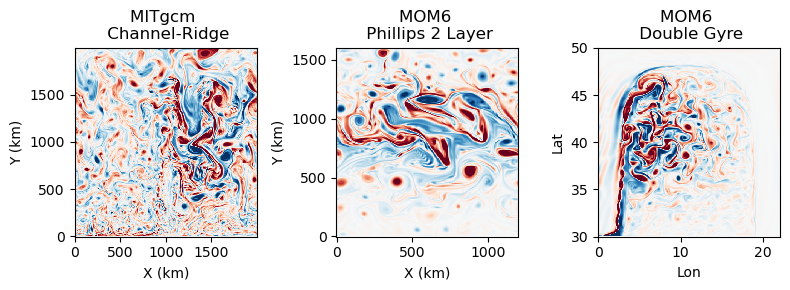

In [87]:
plt.figure(figsize=(8, 3.))

plt.subplot(131)
(ds_MITgcm.zeta/-f).isel(time=-1).sel(Z=-500, method='nearest').plot(x='XG_km', y='YG_km',
    robust=True, add_colorbar=False)
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
plt.title('MITgcm \n Channel-Ridge')

plt.subplot(132)
(ds_P2L.RV/f).isel(Time=-1, zl=0).plot(robust=True, add_colorbar=False)
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
plt.title('MOM6 \n Phillips 2 Layer')

plt.subplot(133)
(ds_DG.RV/f).isel(Time=-1, zl=0).plot(robust=True, add_colorbar=False)
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.title('MOM6 \n Double Gyre')

plt.tight_layout()

plt.savefig('figure1.png', dpi=250)